# RNA-seq analysis with DESeq2
## Largely from Stephen Turner, @genetics_blog


<!-- Using data from GSE37704, with processed data available on Figshare DOI: 10.6084/m9.figshare.1601975.
This dataset has six samples from GSE37704, where expression was quantified by either:
* Mapping to to GRCh38 using STAR then counting reads mapped to genes with featureCounts under the union-intersection model, or
* Alignment-free quantification using Sailfish, summarized at the gene level using the GRCh38 GTFile. Both datasets are restricted to protein-coding genes only.

We're using the Sailfish data. -->

This example comes from [a gist template for DESeq analyis](https://gist.github.com/stephenturner/f60c1934405c127f09a6) and a [blog post](
http://www.gettinggeneticsdone.com/2015/12/tutorial-rna-seq-differential.html), both by Stephen Turner.

First we pull in the data from a remote copy:

# set up the countdata, and metadata

In [1]:
# sample data downloaded from https://bioinfo.umassmed.edu/index.php?p=35#p1e3

In [74]:
countdata <- read.csv("data.tsv", header=T, sep="\t",row.names=1)

In [75]:
head(countdata)

,transcript,exper_rep1,exper_rep2,exper_rep3,control_rep1,control_rep2,control_rep3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AK212155,uc029wnt.1,0.00,0.00,0,0.0,0,0
Sp2,"uc007ldf.1,uc007ldg.1",52.00,47.00,36,99.0,53,66
AK051368,uc009coj.1,4.39,1.11,0,1.1,0,0
Ubiad1,uc008vup.1,121.00,125.00,65,134.0,95,111
Src,"uc008npa.1,uc008npb.1,uc012cia.1",21.00,35.00,20,43.0,22,32
Racgap1,"uc007xpx.2,uc007xpy.2,uc007xpz.2",9.00,20.00,11,14.0,10,7


In [76]:
countdata=countdata[,-1]


In [77]:
countdata=round(countdata,0)

In [78]:
head(countdata)

,exper_rep1,exper_rep2,exper_rep3,control_rep1,control_rep2,control_rep3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AK212155,0,0,0,0,0,0
Sp2,52,47,36,99,53,66
AK051368,4,1,0,1,0,0
Ubiad1,121,125,65,134,95,111
Src,21,35,20,43,22,32
Racgap1,9,20,11,14,10,7


In [79]:
countdata=countdata[,order(colnames(countdata),decreasing = F)]

In [80]:
#colnames(countdata)=gsub(".rsem","",colnames(countdata))

In [81]:
nrow(countdata)

[1] 30739

In [82]:
countdata=countdata[order(rowMeans(countdata),decreasing=TRUE),]

In [83]:
countdata=countdata[rowMeans(countdata)>0,]

In [84]:
#rowMeans(countdata)

In [85]:
nrow(countdata)

[1] 18881

In [86]:
head(countdata)

,control_rep1,control_rep2,control_rep3,exper_rep1,exper_rep2,exper_rep3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Gm2083,951450,1301298,497372,1281028,814181,412822
Alb,948299,507852,637572,512624,694234,264932
DQ539915,469424,395011,233763,567438,398149,216445
Mup7,180543,423760,101172,574418,350964,172637
Apoe,306224,181557,209187,308929,504281,154482
Cytb,251382,192767,170016,315697,232647,107945


In [87]:
meta=data.frame(cbind(colnames(countdata),c("ctrl","ctrl","ctrl","expr","expr","expr")))
colnames(meta)=c("id","condition")

In [88]:
rownames(meta)=meta$id

In [89]:
#meta=data.frame(meta[,-1])

In [90]:
meta

,id,condition
,<chr>,<chr>
control_rep1,control_rep1,ctrl
control_rep2,control_rep2,ctrl
control_rep3,control_rep3,ctrl
exper_rep1,exper_rep1,expr
exper_rep2,exper_rep2,expr
exper_rep3,exper_rep3,expr


In [91]:
head(countdata)

,control_rep1,control_rep2,control_rep3,exper_rep1,exper_rep2,exper_rep3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Gm2083,951450,1301298,497372,1281028,814181,412822
Alb,948299,507852,637572,512624,694234,264932
DQ539915,469424,395011,233763,567438,398149,216445
Mup7,180543,423760,101172,574418,350964,172637
Apoe,306224,181557,209187,308929,504281,154482
Cytb,251382,192767,170016,315697,232647,107945


# feed the data to DESeq2

In [92]:
coldata <- meta

In [93]:
# Convert to matrix
countdata <- as.matrix(countdata)
head(countdata)

,control_rep1,control_rep2,control_rep3,exper_rep1,exper_rep2,exper_rep3
Gm2083,951450,1301298,497372,1281028,814181,412822
Alb,948299,507852,637572,512624,694234,264932
DQ539915,469424,395011,233763,567438,398149,216445
Mup7,180543,423760,101172,574418,350964,172637
Apoe,306224,181557,209187,308929,504281,154482
Cytb,251382,192767,170016,315697,232647,107945


And we start the bioconductor DESeq2 analysis worfklow, first by initializing the DESeqDataSeet from the matrix we've created above:

In [94]:
suppressPackageStartupMessages(library(DESeq2))
dds <- DESeqDataSetFromMatrix(countData=countdata, colData=coldata, design=~condition)
dds

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 18881 6 
metadata(1): version
assays(1): counts
rownames(18881): Gm2083 Alb ... Rnf207 AK016328
rowData names(0):
colnames(6): control_rep1 control_rep2 ... exper_rep2 exper_rep3
colData names(2): id condition

And now running the DESeq Pipeline:

In [95]:
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



## Quality Control Plots

We next perform some basic QC plots to examine the data behvaiour, first by looking at dispersions to ensure they behave smoothly and broadly decrease with counts:

In [96]:
#?plotDispEsts

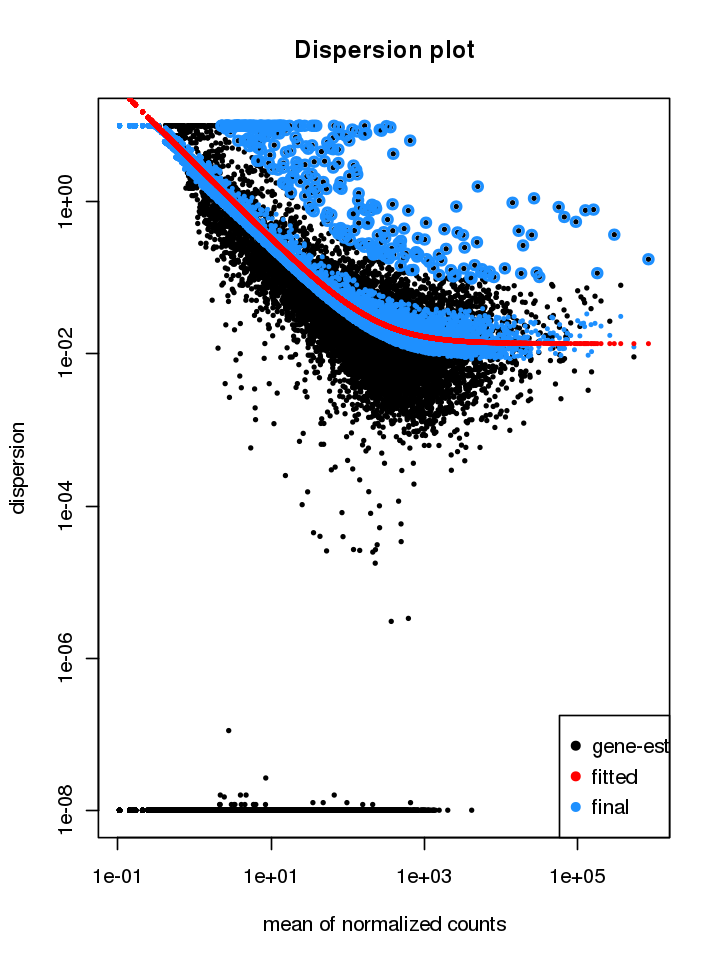

In [97]:
options(repr.plot.height=8, repr.plot.width=6)
plotDispEsts(dds, main="Dispersion plot")

In general we're most interested in logs of the counts; DESeq has a regularlized log transform built in:

In [98]:
head(assay(dds))

,control_rep1,control_rep2,control_rep3,exper_rep1,exper_rep2,exper_rep3
Gm2083,951450,1301298,497372,1281028,814181,412822
Alb,948299,507852,637572,512624,694234,264932
DQ539915,469424,395011,233763,567438,398149,216445
Mup7,180543,423760,101172,574418,350964,172637
Apoe,306224,181557,209187,308929,504281,154482
Cytb,251382,192767,170016,315697,232647,107945


In [99]:
# Regularized log transformation for clustering/heatmaps, etc
rld <- rlogTransformation(dds)
head(assay(rld))

,control_rep1,control_rep2,control_rep3,exper_rep1,exper_rep2,exper_rep3
Gm2083,19.37180,20.03679,19.17859,20.04732,19.49562,19.56679
Alb,19.14014,18.99377,19.14690,19.02463,19.13509,18.96503
DQ539915,18.28852,18.52688,18.05299,18.87513,18.40712,18.53980
Mup7,17.33741,18.41799,17.21427,18.72882,18.11664,18.16431
Apoe,17.72852,17.67235,17.74788,18.14476,18.43015,18.05365
Cytb,17.41330,17.57038,17.42460,18.03107,17.60514,17.60155


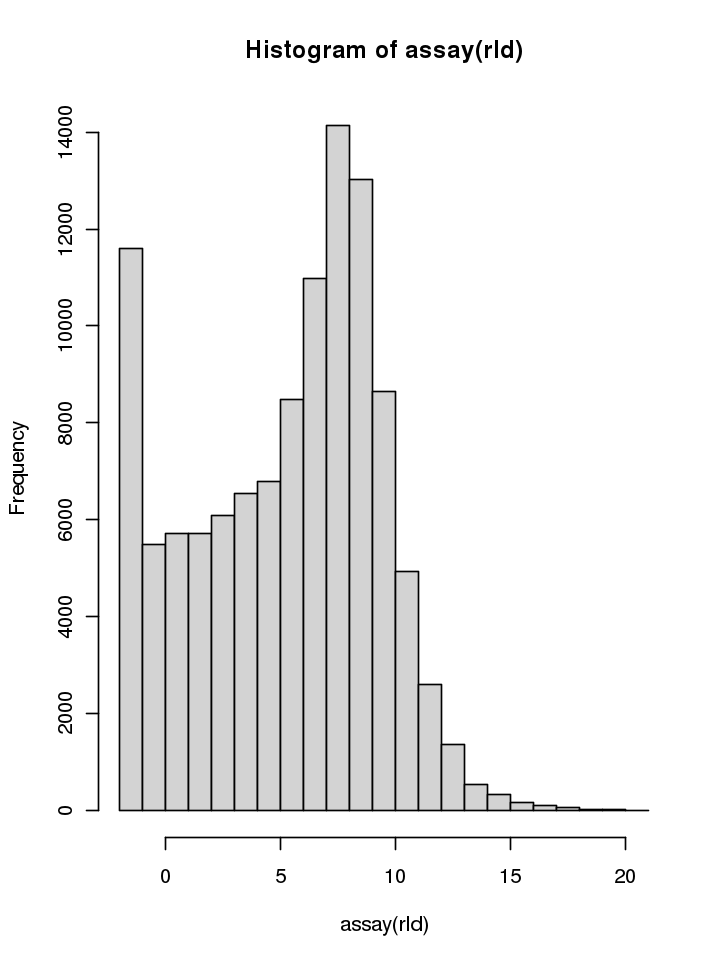

In [100]:
hist(assay(rld))

Now we'll make sure sure the samples cluster together by condition, first by clustering and heatmaps:

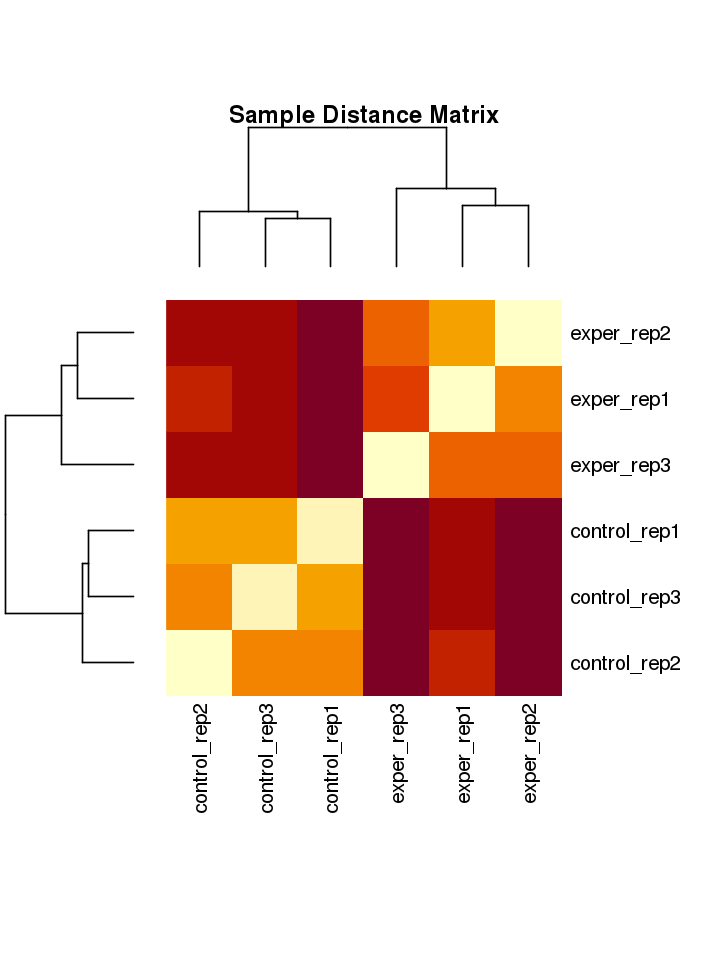

In [101]:
library(RColorBrewer)
mycols <- brewer.pal(8, "Dark2")[1:length(unique(coldata$condition))]

# Sample distance heatmap
sampleDists <- as.matrix(dist(t(assay(rld))))
heatmap(as.matrix(sampleDists),
          ColSideColors=mycols[coldata$condition], RowSideColors=mycols[coldata$condition],
          margin=c(10, 10), main="Sample Distance Matrix")

And next by PCA, using two slightly different visualizations, one supplied by DESeq and one by Stephen Turner:

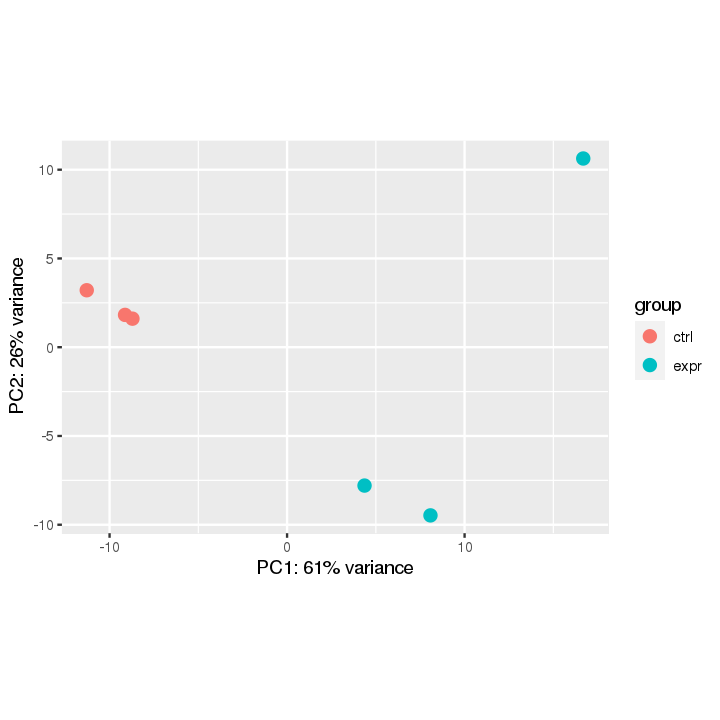

In [102]:
options(repr.plot.height=6, repr.plot.width=6)
DESeq2::plotPCA(rld, intgroup="condition")

The case/control samples seem very clearly distinguished in the first principal component.  

## Differential Expression Analysis

Now we perform the differential expression analysis using DESeq2's built in methods, and then order the results by adjusted p-value:

In [103]:
# Get differential expression results
res <- results(dds,alpha = 0.1)
## Order by adjusted p-value
res <- res[order(res$padj), ]

In [104]:
res

log2 fold change (MLE): condition expr vs ctrl 
Wald test p-value: condition expr vs ctrl 
DataFrame with 18881 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat      pvalue        padj
         <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
Mug2      5680.928       -2.08126  0.124891  -16.6646 2.36898e-62 3.33410e-58
Gm15441    448.643        4.15340  0.250291   16.5943 7.66127e-62 5.39123e-58
Apoa4    46478.497        3.14323  0.205332   15.3080 6.75853e-53 3.17065e-49
Ildr2      650.430       -2.03860  0.146880  -13.8794 8.44311e-44 2.97071e-40
Prg4       901.032       -2.26089  0.165469  -13.6635 1.67723e-42 4.72107e-39
...            ...            ...       ...       ...         ...         ...
BC051019  0.142661       1.441750   4.08047  0.353329    0.723842          NA
AK144297  0.306182       1.441750   4.08047  0.353329    0.723842          NA
Klk1b26   0.306182       1.441750   4.08047  0.353329    0.723842          NA
Rnf207    0

In [105]:
res <- res[complete.cases(res),]

In [106]:
res

log2 fold change (MLE): condition expr vs ctrl 
Wald test p-value: condition expr vs ctrl 
DataFrame with 14074 rows and 6 columns
             baseMean log2FoldChange     lfcSE         stat      pvalue
            <numeric>      <numeric> <numeric>    <numeric>   <numeric>
Mug2         5680.928       -2.08126  0.124891     -16.6646 2.36898e-62
Gm15441       448.643        4.15340  0.250291      16.5943 7.66127e-62
Apoa4       46478.497        3.14323  0.205332      15.3080 6.75853e-53
Ildr2         650.430       -2.03860  0.146880     -13.8794 8.44311e-44
Prg4          901.032       -2.26089  0.165469     -13.6635 1.67723e-42
...               ...            ...       ...          ...         ...
Rap2b        56.25669   -3.00909e-04  0.304472 -0.000988298    0.999211
Fbxo40        7.12749    8.39767e-04  0.907350  0.000925515    0.999262
Itpr3        24.37602   -2.76800e-04  0.451965 -0.000612437    0.999511
Slc2a4rg-ps  74.30042    6.62403e-05  0.269096  0.000246158    0.999804
AK010

In [107]:
#res$pvalue <- ifelse(res$pvalue < 1.e-250, 1.e-250, res$pvalue)

summary(res)


out of 14074 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2929, 21%
LFC < 0 (down)     : 3016, 21%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [108]:
resdata <- merge(as.data.frame(res), as.data.frame(counts(dds, normalized=TRUE)), by="row.names", sort=FALSE)
names(resdata)[1] <- "Gene"
resdata$Gene <- as.character(resdata$Gene)
head(resdata)

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,control_rep1,control_rep2,control_rep3,exper_rep1,exper_rep2,exper_rep3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Mug2,5680.9282,-2.081259,0.1248907,-16.66464,2.368980e-62,3.334102e-58,9808.17294,9279.21607,8488.36649,2238.9908,2292.2767,1978.5462
2,Gm15441,448.6429,4.153403,0.2502907,16.59432,7.661269e-62,5.391235e-58,61.76987,55.54041,24.56562,936.5647,961.2497,652.1670
3,Apoa4,46478.4967,3.143226,0.2053319,15.30802,6.758534e-53,3.170654e-49,13777.20224,7621.92983,6951.12559,82656.1616,77865.5081,89999.0528
4,Ildr2,650.4302,-2.038603,0.1468796,-13.87941,8.443113e-44,2.970709e-40,1031.17865,1090.97239,1014.74907,235.4151,260.2136,270.0523
5,Prg4,901.0324,-2.260887,0.1654691,-13.66350,1.677232e-42,4.721072e-39,1572.61047,1566.04127,1338.82628,377.0717,294.4523,257.1926
6,Gstt2,1724.1479,1.718198,0.1282525,13.39700,6.295992e-41,1.476830e-37,748.80210,846.99129,818.22411,2785.2352,2689.4449,2456.1897


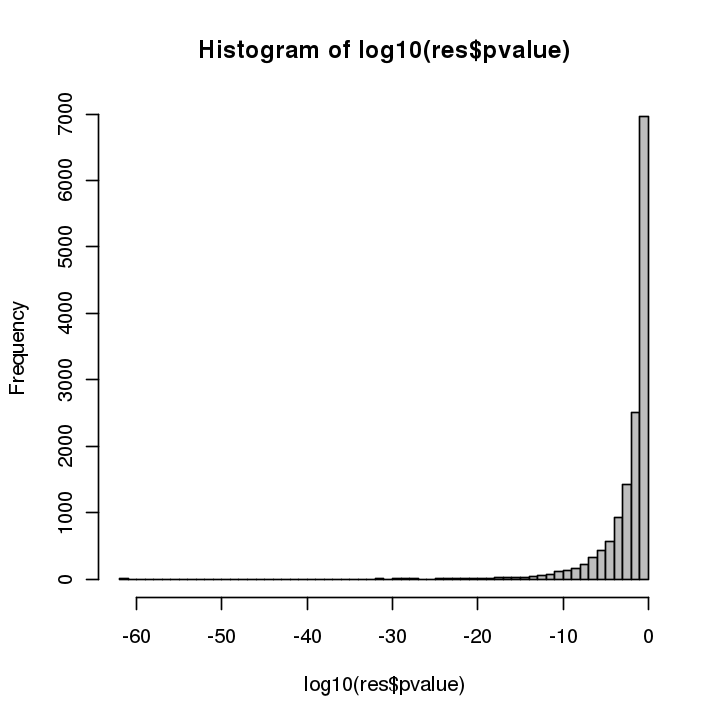

In [109]:
hist(log10(res$pvalue), breaks=50, col="grey")

As we can see, there's a substantial number of genes with extremely small p-values.

### MA plots

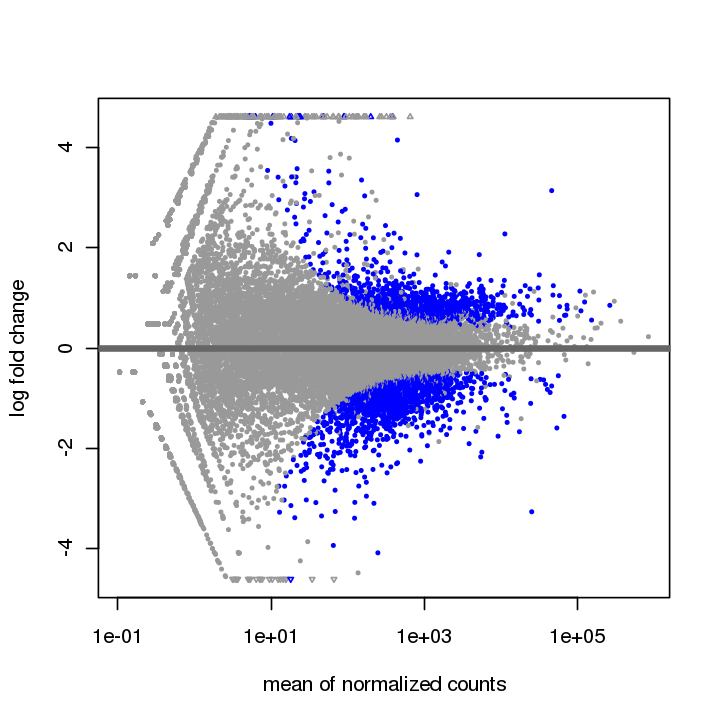

In [110]:
DESeq2::plotMA(dds,alpha = 0.001)

## Volcano Plot

In [111]:
## Volcano plot with "significant" genes labeled
library(ggrepel)
set.seed(42)
volcanoplot <- function (res, lfcthresh=2, sigthresh=0.0005, topsig=10, main="Volcano Plot", 
                         legendpos="bottomright", labelsig=TRUE, textcx=1, ...) {
  with(res, plot(log2FoldChange, -log10(pvalue), pch=20, main=main, ...))
  with(subset(res, padj<sigthresh ), points(log2FoldChange, -log10(pvalue), pch=20, col="red", ...))
  with(subset(res, abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(pvalue), pch=20, col="orange", ...))
  with(subset(res, padj<sigthresh & abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(pvalue), pch=20, col="green", ...))
  if (labelsig) {
    #with(subset(res, -log10(pvalue) != Inf), text(log2FoldChange[1:topsig], -log10(pvalue[1:topsig]), labels=Gene, cex=textcx, col="blue"))
    with(subset(res, -log10(pvalue) != Inf), points(log2FoldChange[1:topsig], -log10(pvalue[1:topsig]), col="blue", pch=20, ...)) 
  }
  legend(legendpos, xjust=1, yjust=1, legend=c(paste("FDR<",sigthresh,sep=""), paste("|LogFC|>",lfcthresh,sep=""), "both", "most significant"), pch=20, col=c("red","orange","green","blue"))
  
}

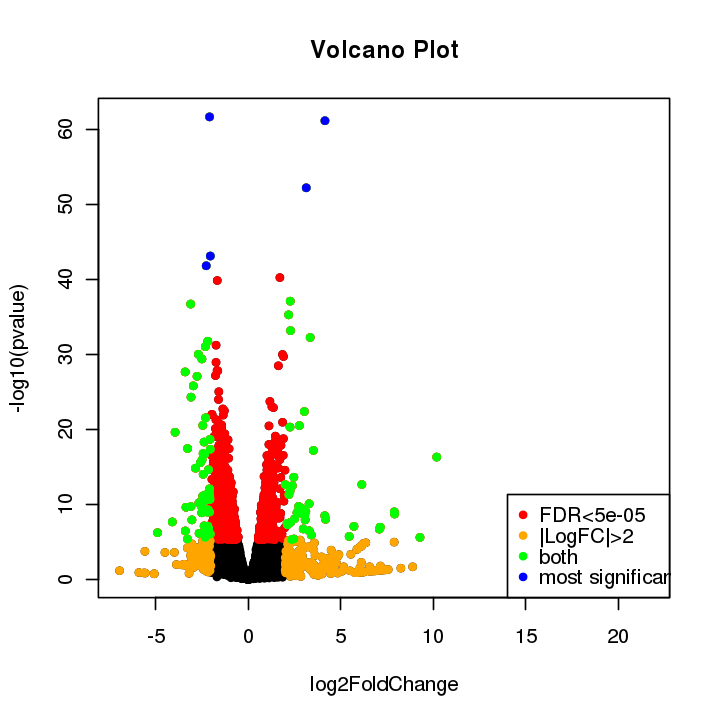

In [112]:
#resdata
options(repr.plot.height=6, repr.plot.width=6)
volcanoplot(resdata, lfcthresh=2, sigthresh=0.00005, textcx=.8, topsig=5)

# for functional annotations, GO analysis, you could go to 
 Webgestalt, or use package such as http://www.webgestalt.org/ <br>
 clusterProfiler https://yulab-smu.top/clusterProfiler-book/ <br>
 multipenrichGem.https://jmw86069.github.io/multienrichjam/ https://jmw86069.github.io/multienrichjam/articles/importIPA.html <br>
 IPA (commercial, available to NIH) 

In [113]:
saveRDS(resdata,"data/data2_resdata.rds")